In [44]:
import pandas as pd
import numpy as np
import csv
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from scipy.stats import ttest_ind
from scipy.stats import zscore
import scipy.cluster.hierarchy as hier
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import AalenAdditiveFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from matplotlib.mlab import PCA as mlabPCA 
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import pylab as pl


kmf=KaplanMeierFitter()
cf = CoxPHFitter()
aaf = AalenAdditiveFitter(fit_intercept=False)


def func_for_row(row,df1,df2): #function to copy rows
    df1.loc[row]=df2.T[row]

def func_for_col(col,df1,df2,j='default',i2='none'): #funtion to copy colums
    
    if i2=='none':
        if j=='default':
            df1[col]=df2[col]
        else:
            if j<10:
                df1['clust'+'0'+str(j)+' '+col]=df2[col]
            else:
                df1['clust'+str(j)+' '+col]=df2[col]
    else:
        if j=='default':
            df1[i2]=df2[col]
        else:
            if j<10:
                df1['clust'+'0'+str(j)+' '+i2]=df2[col]
            else:
                df1['clust'+str(j)+' '+i2]=df2[col]
            
def filtering_genes(list1,df): #extracting genes that we want from the data frame
    new_df=pd.DataFrame(df.head())
    new_df=pd.DataFrame(index=new_df.T.index)
    new_df=new_df.T
    [func_for_row(i,new_df,df) for i in df.T if True in [True for j in list1 if j in i[0:len(j)]]]
    return new_df

def filtering_genes_faster(list1,df): #extracting genes that we want from the data frame
    return df.loc[list1,:]

def std_check(df): #eleminating the genes has std as 0
    new_df=pd.DataFrame(index=df.index)
    new_df=df
    def fnc(i,df1,df2):
        df1=df2.drop(i)
    [fnc(i,new_df,df) for i in df.index if df.T[i].std()<= 0]
    return new_df


def ttest_normal(df): 
    tumor_indexes=[]
    normal_indexes=[]
    [normal_indexes.append(i) for i in df if i[13:15]=='11'] #taking  the samples which has normal data
    [tumor_indexes.append(j) for j in df if j[13:15]=='01'] #taking  the samples which has tumor data
    if len(normal_indexes)==0:
        return 'there are no normal samples'
    elif len(tumor_indexes)==0:
        return 'there are no tumor samples'
    #constracting a data frame of tumor samples
    primary_tumor_data=pd.DataFrame(index=df.index) 
    [ func_for_col(i,primary_tumor_data,df) for i in tumor_indexes]
    #constracting a data frame of normal samples
    normal_data=pd.DataFrame(index=df.index)
    [ func_for_col(i,normal_data,df) for i in normal_indexes]
    
    ttest_results={}
    def testing1(i):# the fuction that apply ttest for each gene
        gene_name=primary_tumor_data.index[i]
    
        x=primary_tumor_data.T[primary_tumor_data.index[i]].astype(float)   
        y=normal_data.T[normal_data.index[i]].astype(float)    
        r=ttest_ind(x,y,equal_var=False)
        ttest_results.update({gene_name:list(r)})
        
    [ testing1(i) for i in range(0,primary_tumor_data.count()[1])]
    results_table=pd.DataFrame(ttest_results, index=['t_score','p_value'])
    results_table
    return results_table
    
    
def ttest_paired(df):
    indexes=[]
            # taking the samples which have both normal and tumor data
    [ indexes.append([j for j in df.T.index if i[0:12] in j]) for i in df.T.index if i[13:15]=='11']
    if len(indexes)==0:
        print 'there are no normal samples'

    #constructing a data frame of tumor samples that has also normal samples
    primary_tumor_data=pd.DataFrame(index=df.index)
    [func_for_col(indexes[i][0],primary_tumor_data,df) for i in range(len(indexes))]
    
    #constructing a data frame of normal samples
    normal_data=pd.DataFrame(index=df.index)
    [func_for_col(indexes[i][1],normal_data,df) for i in range(len(indexes))]

    ttest_results={}
    def testing2(i):# the fuction that apply ttest for each gene
    
        gene_name=primary_tumor_data.index[i]
        x=primary_tumor_data.T[primary_tumor_data.index[i]].astype(float)  
        y=normal_data.T[normal_data.index[i]].astype(float)
        r=ttest_rel(x,y)
        ttest_results.update({gene_name:list(r)})
        
    [ testing2(i) for i in range(0,primary_tumor_data.count()[1])]
    results_table=pd.DataFrame(ttest_results, index=['t_score','p_value'])
    return results_table

def checking_p_value(ttest_df): #checking if p values of genes are less than 0.05/total gene number 
    significant_genes=[]
    [significant_genes.append(i) for i in ttest_df if ttest_df[i][1]<0.05/len(ttest_df.T)]
    return significant_genes

def filtering_row_info(list1,df): #extracting necessary info rows from clinical data 
    new_df=pd.DataFrame(index=df.T.index)
    new_df=new_df.T
    [func_for_row(row,new_df,df) for row in df.T if True in [True for i in list1 if i in row]]
    return new_df
    
def merging_rows(features_list,df):#merging rows to collect info from different rows to put into one row
    all_merged_data=pd.DataFrame(index=df.T.index)
    all_merged_data=all_merged_data.T
    for x in features_list:
        x_sum=[ df.T[i].fillna(' ')  for i in df.index if x in i]
        x_sum1=x_sum[0]
        for i in range(1,len(x_sum)):
            x_sum1=x_sum1+x_sum[i]
        x_sum=x_sum1
        all_merged_data.loc[x]=x_sum
    return all_merged_data

def roman_to_int(df): #func to transform roman letters into intigers
    def roman(word):
        if type(word)==float or type(word)==int:
            return word
        elif 'stage iv' in str(word):
            return 4
        elif 'stage iii' in str(word):
            return 3
        elif 'stage ii' in str(word):
            return 2
        elif 'stage i' in str(word):
            return 1
        else:
            return 
    df.loc['patient.stage_event.pathologic_stage']=[roman(i) for i in df.T['patient.stage_event.pathologic_stage']]
    return df

def filter_age(df): #filtering according to age, taking the ones below 75
    new_df=pd.DataFrame(index=df.index)
    [func_for_col(i,new_df,df)for i in df if int(df[i][0])<75]
    return new_df

def extracting_recep_data(df): #extracting receptor status data from several rows and forming as one row
    receptor_data={} 
    [receptor_data.update({df.T.index[i]:1})for i in range(len(df.T)) if df.T['patient.breast_carcinoma_estrogen_receptor_status'][i]=='positive' or df.T['patient.breast_carcinoma_progesterone_receptor_status'][i]=='positive' and df.T['patient.lab_proc_her2_neu_immunohistochemistry_receptor_status'][i]=='positive']
    [receptor_data.update({df.T.index[i]:2})for i in range(len(df.T)) if df.T['patient.breast_carcinoma_estrogen_receptor_status'][i]=='positive' or df.T['patient.breast_carcinoma_progesterone_receptor_status'][i]=='positive' and df.T['patient.lab_proc_her2_neu_immunohistochemistry_receptor_status'][i]=='negavite']
    [receptor_data.update({df.T.index[i]:3})for i in range(len(df.T)) if df.T['patient.breast_carcinoma_estrogen_receptor_status'][i]=='negative' and df.T['patient.breast_carcinoma_progesterone_receptor_status'][i]=='negative' and df.T['patient.lab_proc_her2_neu_immunohistochemistry_receptor_status'][i]=='positive']
    [receptor_data.update({df.T.index[i]:4})for i in range(len(df.T)) if df.T['patient.breast_carcinoma_estrogen_receptor_status'][i]=='negative' and df.T['patient.breast_carcinoma_progesterone_receptor_status'][i]=='negative' and df.T['patient.lab_proc_her2_neu_immunohistochemistry_receptor_status'][i]=='negative']

    receptor_data=pd.DataFrame(receptor_data,index=['receptor_data'])
    new_df=pd.DataFrame(index=df.index)
    [func_for_col(i,new_df,df) for i in df if i in receptor_data.T.index]
    new_df.loc['receptor_data']=receptor_data.T['receptor_data']
    return new_df

def dtd_less_30(df): #eleminating days to death lower than 30
    new_df=pd.DataFrame(index=df.index)
    for i in df:
        if str(df.T['patient.days_to_death'][df.T.index.get_loc(i)])=='nan':
            func_for_col(i,new_df,df)
        elif int(df.T['patient.days_to_death'][df.T.index.get_loc(i)])>30 and int(df.T['patient.days_to_death'][df.T.index.get_loc(i)])<=3650 :
            func_for_col(i,new_df,df)
    return new_df

def equaling_dfs(df1,df2,cond):#func for taking the junction between clin data and gene exp data
                            #df1 for gene_data df2 for clin_data
    def drop_func(i,df):
            df=df.drop(i,axis=1,inplace=True)                           
    if cond==0:                #cond is for adding normal samples or not.
        temp1=pd.DataFrame(index=df1.index)
        [func_for_col(i,temp1,df1) for i in df1 for j in df2 if j in i]
        
        [ drop_func(i,temp1) for i in temp1.T.index[1:] if  i[13:15]!='01']
    
        temp2=pd.DataFrame(index=df2.index)
        [func_for_col(i,temp2,df2) for i in df2 for j in temp1 if i in j]
        return [temp1,temp2]
    elif cond==1:
        temp1=pd.DataFrame(index=df1.index)
        [func_for_col(i,temp1,df1) for i in df1 for j in df2 if j in i]
        [ drop_func(i,temp1.T) for i in temp1.T.index[1:] if  i[13:15]!='01' and i[13:15]!='11']
    
        temp2=pd.DataFrame(index=df2.index)
        [func_for_col(i,temp2,df2) for i in df2 for j in temp1 if i in j]
        return [temp1,temp2]
    
    else:
        print('Wrong condition entered it must be 0 or 1')
        
def clustering(z_score):# Hierarchical clustring
    sns.set() #clustring with seaborn according to z score
    snsclust=sns.clustermap(z_score.astype(np.float64),linewidth=0,vmax=4)
    snsclust.dendrogram_col.reordered_ind
    flats=hier.fcluster(snsclust.dendrogram_col.linkage,37,criterion='distance')#according to gene size the number here soul be changed to obtain good clusters
    return [flats,snsclust,max(flats)]

def clustering2(z_score,k): # K-means clustring
    import Pycluster
    sns.heatmap(z_score,linewidth=0,vmax=4)
    x=Pycluster.kcluster(z_score.T,k)
    return x[0]+1

def eleminating_small_cls(df,flats):
    df=pd.DataFrame(flats,index=df.T.index)
    df=df.T
    clst={}
    rng=range(1,max(flats)+1)
    [clst.update({str(i):0})for i in rng]
    def addition(dic,key):
        dic[key]=dic[key]+1
    [addition(clst,str(int(df[i])))for i in df]
    clst1=pd.DataFrame(clst,index=['counts'])
    clst1=clst1.where(clst1>20)
    clst1=clst1.T.dropna()
    
    clst=pd.DataFrame(clst,index=['counts'])
    clst=clst.where(clst<20)
    clst=clst.T.dropna()
    clst=list(clst.index.astype(int))
    for i in clst:
        df=df[df!=i]
    df=df.T.dropna()
    return [df.T,clst1.index.astype(int)]
def reconstruction_of_data(df1,df2,dic): #reconsturcting expression and clinical data according to clustring.
    a=lambda x: x[0:12]
    
    lst=[]
    for i in range(len(dic.columns)):
        lst.append(a(dic.columns[i]))

    rec_g_data=df1.T.loc[dic.columns,:]
    rec_c_data=df2.T.loc[lst,:]
    rec_g_data.index='clust'+pd.Series(list(dic.values.astype(int)[0].astype(str)))+' '+pd.Series(dic.columns)
    rec_c_data.index='clust'+pd.Series(list(dic.values.astype(int)[0].astype(str)))+' '+pd.Series(lst)
    rec_g_data=rec_g_data.sort_index()
    rec_c_data=rec_c_data.sort_index()
    
    return [rec_g_data.T,rec_c_data.T]

def survival(df): #constructs survival plot and returns days of death and alive status to use in different functions
    df.loc['patient.days_to_death']=df.T['patient.days_to_death'].fillna(3650)
    T=df.T['patient.days_to_death']
    E=df.T['patient.vital_status']
    E=E.replace('alive',0)
    E=E.replace('dead',1)
    kmf.fit(T,E,label='cluster'+df.T.index[0][5:7])
    kmf.plot(ax=ax,show_censors=True)
    return [T,E]

def clusters_as_row(df): #to create a row represending the clusters for cox hazard
    dic={}
    [ dic.update({i: int(i[5:7])}) for i in df]
    dic=pd.DataFrame(dic,index=['clusters'])
    df.loc['clusters']=dic.T[dic.index[0]]
    return df

def cox_hazard(df):
    df.loc['patient.days_to_death']=df.T['patient.days_to_death'].fillna(3650)
    T=df.T['patient.days_to_death']
    E=df.T['patient.vital_status']
    E=E.replace('alive',0)
    E=E.replace('dead',1)
    regression_dataset={'clusters': df.T['clusters'],'pathologic_stage' : df.T['patient.stage_event.pathologic_stage'].fillna(0) ,'age': df.T['patient.age_at_initial_pathologic_diagnosis'],'subtype_status': df.T['receptor_data'],'T':T,'E':E}
    regression_dataset=pd.DataFrame(regression_dataset)
    regression_dataset=regression_dataset.fillna(0).astype(int)
    cf.fit(regression_dataset, 'T', event_col='E')
    cf.fit(regression_dataset, 'T', event_col='E')

    return cf.summary
    
def slicing_df(df,clst_no):#slicing data frame to obtain each cluster for analysing one by one
    clst_no=str(clst_no)
    
    temp_df=pd.DataFrame(index=df.index)
    [[func_for_col(i,temp_df,df)for i in df if 'clust'+clst_no in i ]]
    return temp_df

def survival_significiance(list1):# checking if the survival is significiant between clusters.
    l=[]
    for i in range(0,len(list1)):
        [l.append(['c'+list1[i][0].index[0][5:7]+' vs '+'c'+list1[j][0].index[0][5:7],logrank_test(list1[i][0], list1[j][0], list1[i][1], list1[j][1], alpha=.99 )]) for j in range(0,len(list1)) if i<j]
    return l

def ttest_n_for_clst(df1,df2):#normal ttest function for determining gene expression significance between two clusters.
    ttest_results={}
    def testing1(i):
        gene_name=df1.index[i]
    
        x=df1.T[df1.index[i]].astype(float)     
        y=df2.T[df2.index[i]].astype(float) 
        r=ttest_ind(x,y,equal_var=False)
        ttest_results.update({gene_name:list(r)})
        
    [ testing1(i) for i in range(0,df1.count()[1])]
    results_table=pd.DataFrame(ttest_results, index=['t_score','p_value'])
    results_table
    return results_table

def determining_deg_btw_clst(df,c_num1,c_num2):#the result of this function is diferrentially expressed genes between two clusters
    c1_df=pd.DataFrame(index=df.index)
    c2_df=pd.DataFrame(index=df.index)
    [func_for_col(i,c1_df,df) for i in df if int(i[5:7])==c_num1]
    [func_for_col(i,c2_df,df) for i in df if int(i[5:7])==c_num2]
    return ttest_n_for_clst(c1_df,c2_df)
    
def pca_plot(df):
    pca = PCA(n_components=2)
    pca.fit(df.T.astype(float))
    x=pca.transform(df.T.astype(float))
    return pl.scatter(x[:, 0], x[:, 1]) 

def filtering_outliers(df,lb,ub): #filtering outliers according to lower bound and upper bound that we decide from pca plot.
    pca = PCA(n_components=2)
    pca.fit(df.T.astype(float))
    x=pca.transform(df.T.astype(float))
    x=pd.DataFrame(x,index=df.T.index)
    x=x[lb<x]
    x=x[ub>x]
    x=x.dropna()
    df=df.T.loc[x.T.columns,:]
    return df.T

def elbow_curve(df): # elbow curve for determining k for k-means.
    # we use z-score matris of genes and return it to be used in clustring.
    z_score={}
    [z_score.update({i:zscore(df.T[i].astype(np.float64))}) for i in df.T if i[13:15]!='11']
    z_score=pd.DataFrame(z_score,index=df.T.index)
    z_score=z_score.T #creating z score matrix 
    z_score1=np.array(z_score)

    K = range(1,15)
    KM = [kmeans(z_score1,k) for k in K]
    centroids = [cent for (cent,var) in KM]
    D_k = [cdist(z_score1, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/z_score1.shape[0] for d in dist]
    kIdx = 6
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    return z_score

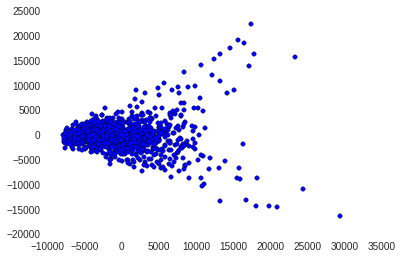

In [45]:
BRCA_data=pd.DataFrame.from_csv('/cellar/users/mkose/Downloads/TCGAdata/data_from_andy/gdac.broadinstitute.org_BRCA.Merge_rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.Level_3.2015040200.0.0/BRCA.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.txt',sep='\t')
BRCA_data=BRCA_data.drop('gene_id')
#filtering by genes
genes_to_filter=['ACTN1','ACTN4','BCAR1','PTK2','PXN','RAC1','TLN','VASP','VCL','ZYX']
gene_data=filtering_genes(genes_to_filter,BRCA_data.astype(float))
gene_data=filtering_genes_faster(checking_p_value(ttest_paired(gene_data)),gene_data)
pca_plot(gene_data)

In [46]:
gene_data=filtering_outliers(gene_data,-10000,10000)
#importing clinical data
clin_data=pd.DataFrame.from_csv('/cellar/users/mkose/Downloads/TCGAdata/data_from_andy/gdac.broadinstitute.org_BRCA.Merge_rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.Level_3.2015040200.0.0/gdac.broadinstitute.org_BRCA.Merge_Clinical.Level_1.2015040200.0.0/BRCA_clin_merged.csv')
clin_data.loc['patient.bcr_patient_barcode']=[a.upper() for a in clin_data.T['patient.bcr_patient_barcode']]
clin_data.loc['patient.bcr_patient_barcode']=[str(a).upper() for a in clin_data.T['patient.bcr_patient_barcode']]
clin_data=clin_data.T.set_index('patient.bcr_patient_barcode')
clin_data=clin_data.T
imp_data=['patient.days_to_death','patient.days_to_last_followup','patient.bcr_patient_barcode','patient.age_at_initial_pathologic_diagnosis','patient.clinical_cqcf.other_diagnosis','patient.clinical_cqcf.tumor_type','micrometastasis_indicator','patient.histological_type_other','patient.vital_status','patient.breast_carcinoma_progesterone_receptor_status','patient.lab_proc_her2_neu_immunohistochemistry_receptor_status','patient.breast_carcinoma_estrogen_receptor_status','patient.stage_event.pathologic_stage']
merging_data=['new_neoplasm_event_type']

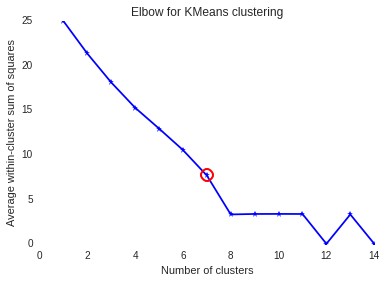

In [47]:
#clinical data processing starts here!!! Filtering clinical data
clin_data=pd.concat([filtering_row_info(imp_data,clin_data),merging_rows(merging_data,clin_data)])
clin_data=extracting_recep_data(clin_data)
clin_data=dtd_less_30(filter_age(roman_to_int(clin_data)))
clind_wth_clstr=pd.DataFrame()
cond=0 #this states if we take normal samples or not
#equaling and reconstracting clinical data frame according to filtered clusters.
temps=equaling_dfs(gene_data,clin_data,cond=cond)
gene_data=temps[0]
clin_data=temps[1]
z_score=elbow_curve(gene_data)

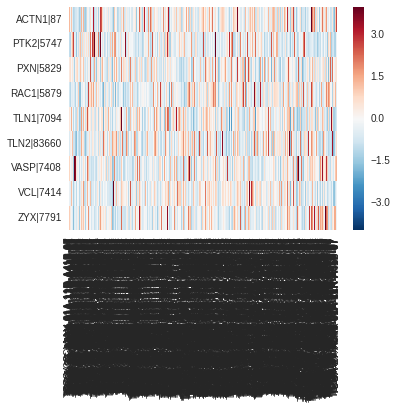

In [48]:
#flats=clustering(z_score)[0]
flats=clustering2(z_score,7)
x=eleminating_small_cls(gene_data,flats)
clusters=x[1]
[rec_gene_data,rec_clin_data]=reconstruction_of_data(gene_data,clin_data,x[0])
rec_clin_data=clusters_as_row(rec_clin_data)

rec_clin_data.T.to_csv('/cellar/users/mkose/cs.csv')
rec_clin_data=pd.DataFrame.from_csv('/cellar/users/mkose/cs.csv') #Im not changing anything here but if I dont do this the plots doesnt show anything
rec_clin_data=rec_clin_data.T

In [49]:
cox_hazard(rec_clin_data)

,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
age,0.256795,1.292780,0.137384,1.869184,0.061597,-0.012531,0.526121
clusters,0.298322,1.347595,0.130740,2.281793,0.022502,0.042020,0.554624
pathologic_stage,0.270918,1.311167,0.138459,1.956662,0.050387,-0.000517,0.542352
subtype_status,0.268340,1.307792,0.110523,2.427910,0.015186,0.051671,0.485009


[['c1  vs c2 ', <lifelines.StatisticalResult: 
  Results
     df: 1
     alpha: 0.99
     t 0: -1
     test: logrank
     null distribution: chi squared
  
     __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
           0.95776 |              0.003 |  Cannot Reject Null |       False       
  >], ['c1  vs c3 ', <lifelines.StatisticalResult: 
  Results
     df: 1
     alpha: 0.99
     t 0: -1
     test: logrank
     null distribution: chi squared
  
     __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
           0.42777 |              0.629 |  Cannot Reject Null |       False       
  >], ['c1  vs c4 ', <lifelines.StatisticalResult: 
  Results
     df: 1
     alpha: 0.99
     t 0: -1
     test: logrank
     null distribution: chi squared
  
     __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
           0.00417 |              8.209 |      Reject Null    |        True       
  >], ['c1  vs c5 ', 

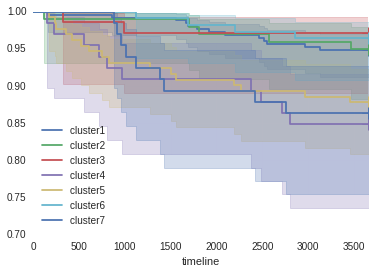

In [50]:
ax = plt.subplot(111)
survival_significiance([survival(slicing_df(rec_clin_data,i)) for i in clusters])

In [51]:
max(flats)

7

In [52]:
map( lambda i : slicing_df(rec_clin_data,i).shape[1],range(1,12))

[251, 99, 70, 66, 131, 112, 66, 0, 0, 0, 0]

In [53]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(rec_clin_data.T['receptor_data'],rec_clin_data.T['clusters'])

0.021713435832823792

In [55]:
determining_deg_btw_clst(rec_gene_data,4,6)

,ACTN1|87,PTK2|5747,PXN|5829,RAC1|5879,TLN1|7094,TLN2|83660,VASP|7408,VCL|7414,ZYX|7791
t_score,-1.078051e+01,1.919245e+01,-4.369177,2.934166,-1.348630e+01,-1.249790e+01,-3.143837,-8.074355e+00,-8.004145e+00
p_value,1.717387e-20,1.991484e-33,0.000028,0.004098,1.781640e-28,9.956013e-23,0.002111,1.471298e-13,4.729474e-13
